In [1]:
import os
import sys

from astroquery.mast import Observations
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

First, calculate how much time HST spent on strong lens science. We'll take this to be the amount of observing time for the Sloan Lens ACS Survey ([Bolton et al. 2008](https://iopscience.iop.org/article/10.1086/589327)). The associated HST proposals (listed below) are taken from this paper.

* [Dark-matter halos and evolution of high-z early-type galaxies
HST Proposal 10174](https://archive.stsci.edu/proposal_search.php?id=10174&mission=hst)
* [Imaging the mass structure of distant lens galaxies
HST Proposal 10494](https://archive.stsci.edu/proposal_search.php?id=10494&mission=hst)
* [Dark Halos and Substructure from Arcs & Einstein Rings
HST Proposal 10798](https://archive.stsci.edu/proposal_search.php?id=10798&mission=hst)
* [Measuring the Mass Dependence of Early-Type Galaxy Structure
HST Proposal 10587](https://archive.stsci.edu/proposal_search.php?id=10587&mission=hst)
* [The Sloan Lens ACS Survey: Towards 100 New Strong Lenses
HST Proposal 10886](https://archive.stsci.edu/proposal_search.php?id=10886&mission=hst)

In [2]:
proposal_ids = ['10174', '10494', '10587', '10798', '10886']

Then, we can query the MAST API for all of the observations associated with these HST Proposal IDs and sum the exposure times.

In [3]:
proposal_dict = {}

for proposal_id in proposal_ids:
    obs_table = Observations.query_criteria(proposal_id=proposal_id)
    proposal_dict[proposal_id] = obs_table

In [4]:
exposure_time_dict = {}
total = 0

for proposal_id, obs_table in proposal_dict.items():
    exposure_times = obs_table['t_exptime']
    total_exposure_time = np.nansum(exposure_times)
    exposure_time_dict[proposal_id] = total_exposure_time
    converted = str(timedelta(seconds=total_exposure_time))
    print(f'Proposal ID {proposal_id}: {total_exposure_time} seconds or {converted}')
    total += total_exposure_time

print(f'\nTotal time: {total} seconds or {timedelta(seconds=total)}')

Proposal ID 10174: 196560.0 seconds or 2 days, 6:36:00
Proposal ID 10494: 537177.0046549999 seconds or 6 days, 5:12:57.004655
Proposal ID 10587: 160440.0 seconds or 1 day, 20:34:00
Proposal ID 10798: 760948.4395600001 seconds or 8 days, 19:22:28.439560
Proposal ID 10886: 571241.0 seconds or 6 days, 14:40:41

Total time: 2226366.444215 seconds or 25 days, 18:26:06.444215


The Design Reference Mission allocates 283.6 days to the imaging component of the High Latitude Wide Area Survey.

In [5]:
hlis_days = 283.6
hlis_sec = hlis_days * 86400

print(f'Design Reference Mission: {hlis_days} days or {str(timedelta(seconds=hlis_sec))}')

Design Reference Mission: 283.6 days or 283 days, 14:24:00


From the [Science Requirements Document](https://asd.gsfc.nasa.gov/romancaa/docs2/RST-SYS-REQ-0020C_SRD.docx), requirement HLIS 2.0.1 says that the high-latitude imaging survey (HLIS) should achive a certain constraint on weak lensing in 1.07 years of observing time. So we interpret this to be the minimum observing time for the HLIS.

In [6]:
# min_hlis_years = 1.07
# min_hlis_sec = min_hlis_years * 31556952

# print(f'Science Requirement Minimum: {min_hlis_years} years or {str(timedelta(seconds=min_hlis_sec))}')

Convert all to hours

In [7]:
for proposal_id, exposure_time in exposure_time_dict.items():
    exposure_time_dict[proposal_id] = exposure_time / 3600

hlis_hours = hlis_sec / 3600
# min_hlis_hours = min_hlis_sec / 3600

# Plot

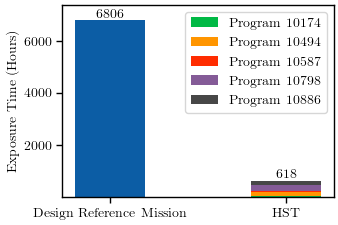

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))
width = 0.4
bottom = 0

ax.bar('Design Reference Mission', hlis_hours, width)
ax.text('Design Reference Mission', hlis_hours + 100, round(hlis_hours), ha='center')

# ax.bar('Science Requirement Minimum', min_hlis_hours, width)

hst_bar = ('HST')
for proposal_id, exposure_time in exposure_time_dict.items():
    label = f'Program {proposal_id}'
    p = ax.bar(hst_bar, exposure_time, width, label=label, bottom=bottom)
    bottom += exposure_time
ax.text('HST', (total / 3600) + 100, round(total / 3600), ha='center')

ax.legend(loc='upper right')  # , prop={'size': 24}
ax.set_ylabel('Exposure Time (Hours)')
ax.set_yticks([2000, 4000, 6000])
ax.set_ylim([0, 7400])

plt.savefig(os.path.join(figure_dir, 'exposure_time_comparison.png'))
plt.show()